In [1]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../data/Season_2016_fav_win.csv')

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
df2=pd.read_csv('../data/Playoffs_2016.csv').drop('Unnamed: 0',axis=1)

Find and eliminate NaNs

In [5]:
df=df.drop(['H_win_probability_subtracted','A_win_probability_subtracted','A_Opp_win_probability_subtracted',
         'H_Opp_win_probability_subtracted'],axis=1)

In [6]:
df2=df2.drop(['H_win_probability_subtracted','A_win_probability_subtracted','A_Opp_win_probability_subtracted',
         'H_Opp_win_probability_subtracted'],axis=1)

In [7]:
df.fav_win.value_counts(normalize=True)

1    0.560544
0    0.439456
Name: fav_win, dtype: float64

In [8]:
df2.fav_win.value_counts(normalize=True)

1    0.628571
0    0.371429
Name: fav_win, dtype: float64

In [30]:
#for col in X_train.columns:
    #print(col)

In [96]:
zero_importance_list=['H_runs','H_slugging_percentage','H_on_base_plus','H_base_out_runs_added','H_putouts',
                     'H_Opp_on_base_percentage','A_batting_average','A_win_probability_for_offensive_player',
                     'A_putouts','A_median_odds','H_median_odds']

In [55]:
tiny_importance_list=['H_at_bats','H_win_probability_added','H_fly_balls']

In [9]:
def data_preprocessing(df, df2):
    X_train = df.drop(['home_win','H_name','A_name','fav_win'], axis=1)
    X_test = df2.drop(['home_win','H_name','A_name','fav_win'], axis=1)
    y_train = df.home_win
    y_test= df2.home_win
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled,y_train,y_test

In [10]:
X_train_scaled,X_test_scaled,y_train,y_test=data_preprocessing(df,df2)

In [14]:
X_test_scaled.drop(['H_Opp_inherited_score','H_Opp_game_score','H_Opp_unknown_bat_type',
                    'H_Opp_inherited_runners'],axis=1,inplace=True)

In [15]:
X_train_scaled.drop(['H_Opp_inherited_score','H_Opp_game_score','H_Opp_unknown_bat_type',
                    'H_Opp_inherited_runners'],axis=1,inplace=True)

In [182]:
zero_imp_train=X_train_scaled.drop(zero_importance_list,axis=1)
zero_imp_test=X_test_scaled.drop(zero_importance_list,axis=1)

## Feature Selection

In [71]:
# pca=PCA(n_components=0.7)
# train_pca=pca.fit_transform(X_train_scaled)
# test_pca=pca.transform(X_test_scaled)

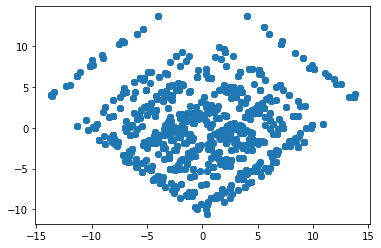

In [51]:
#plt.scatter(train_pca[:,0], train_pca[:,1]);

In [109]:
def feature_select(X_train,y_train,estimator,min_features,step=1):
    estimator2=estimator()
    selector=RFECV(estimator2,min_features_to_select=min_features,step=step)
    selector.fit(X_train,y_train)
    selector.ranking_
    feature_dict=dict(zip(X_train.columns, selector.ranking_))
    best_pred = [k for (k,v) in feature_dict.items() if v == 1]
    
    
    return best_pred

In [110]:
feats= feature_select(zero_imp_train,y_train,LogisticRegression,min_features=10)

In [111]:
X_train_best_log = zero_imp_train[feats]
X_test_best_log = zero_imp_test[feats]

# Logistic Regression

In [112]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    grid_logreg.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Instantiate & fit LogReg model
    log = LogisticRegression(random_state=42, penalty=logreg_penalty, solver=logreg_solver)
    log.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = log.predict(X_test)
    y_pred_proba = log.predict_proba(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(log, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = log.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = log.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(log, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(log, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(log, X_train, y_train)
    plot_confusion_matrix(log, X_test, y_test)
    return y_pred,y_pred_proba

Penalty: l2
Solver: liblinear
Mean Cross-Val Score: 0.5597191464087226
Train Mean Accuracy: 0.5704283360790774
Test Mean Accuracy: 0.6285714285714286
Recall Score: 0.45454545454545453
Precision Score: 0.9090909090909091
F1 Score: 0.6060606060606061


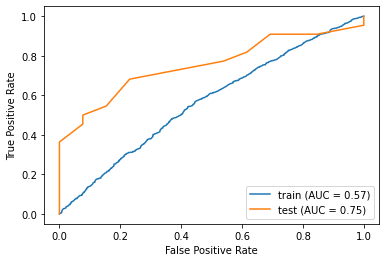

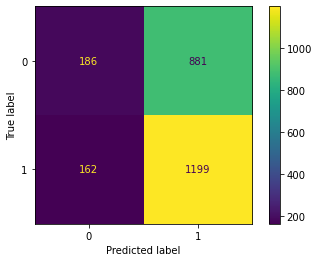

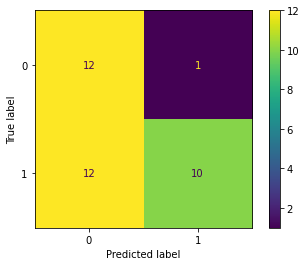

In [113]:
predictions, probabilities=logreg(X_train_best_log,X_test_best_log,y_train,y_test)

If you only bet the games that the model says it is 60% accurate or more than you will hit on about 70% of your bets. In 2016 you would have picked 19 games, 11 underdogs and 8 favorites. You would of hit on 5 underdogs and missed 6 while hitting on all 8 favorites:
This is with predicting on fav_win after dropping the zero_importance features.

In [119]:
predictions

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

### Home_win, zero imp
***

In [123]:
feats= feature_select(zero_imp_train,y_train,LogisticRegression,min_features=10)

In [124]:
X_train_best_log = zero_imp_train[feats]
X_test_best_log = zero_imp_test[feats]

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.582769504900089
Train Mean Accuracy: 0.5889621087314663
Test Mean Accuracy: 0.6
Recall Score: 1.0
Precision Score: 0.5483870967741935
F1 Score: 0.7083333333333333


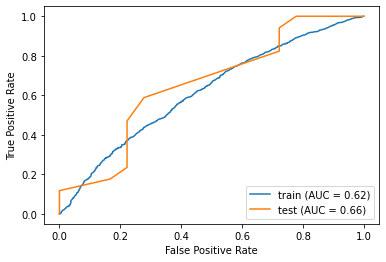

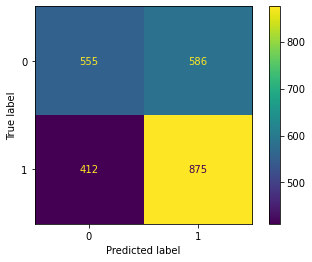

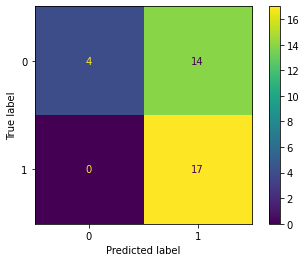

In [125]:
predictions, probabilities=logreg(X_train_best_log,X_test_best_log,y_train,y_test)

In [126]:
predictions

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### more exploration

In [16]:
lr=LogisticRegression()
lr.fit(X_train_scaled,y_train)

LogisticRegression()

In [21]:
predictions=lr.predict(X_test_scaled)

In [22]:
today_winners = np.where(y_test!= predictions,'Away','Home')

In [29]:
probabilities=lr.predict_proba(X_test_scaled)

In [30]:
for i in range(len(today_winners)):
    if today_winners[i] == 'Home':
        print(f'{df2.H_name[i]} {probabilities[i][1]} vs. {df2.A_name[i]} {probabilities[i][0]}')

TOR 0.8797685382706291 vs. BAL 0.12023146172937094
NYM 0.24097449550214387 vs. SFG 0.7590255044978561
TEX 0.09718235082515403 vs. TOR 0.902817649174846
CLE 0.9824726248554739 vs. BOS 0.01752737514452607
TEX 0.09718235082515403 vs. TOR 0.902817649174846
CLE 0.9824726248554739 vs. BOS 0.01752737514452607
CHC 0.8928284291289509 vs. SFG 0.10717157087104912
CHC 0.8928284291289509 vs. SFG 0.10717157087104912
TOR 0.8126058662772977 vs. TEX 0.1873941337227023
WSN 0.9270723477186701 vs. LAD 0.07292765228132991
BOS 0.32047001835797556 vs. CLE 0.6795299816420244
SFG 0.728319535355374 vs. CHC 0.27168046464462603
LAD 0.9044167865701926 vs. WSN 0.09558321342980736
CLE 0.8607572716069697 vs. TOR 0.1392427283930303
CHC 0.9569654480750336 vs. LAD 0.04303455192496641
CLE 0.8607572716069697 vs. TOR 0.1392427283930303
TOR 0.8119657606151082 vs. CLE 0.18803423938489183
LAD 0.9188364316645996 vs. CHC 0.0811635683354004
CHC 0.9569654480750336 vs. LAD 0.04303455192496641
CLE 0.9842321815977307 vs. CHC 0.01576

In [23]:
today_winners

array(['Home', 'Home', 'Home', 'Home', 'Away', 'Home', 'Home', 'Home',
       'Home', 'Home', 'Home', 'Home', 'Away', 'Home', 'Home', 'Away',
       'Away', 'Home', 'Home', 'Home', 'Away', 'Away', 'Home', 'Home',
       'Away', 'Away', 'Away', 'Home', 'Home', 'Away', 'Away', 'Away',
       'Home', 'Away', 'Away'], dtype='<U4')

6 out of 9 correct series predictions

# KNN

In [73]:
#kfeats= feature_select(X_train_scaled,y_train,KNN,min_features=10)
#X_train_best_knn = X_train_scaled[kfeats]
#X_test_best_knn = X_test_scaled[kfeats]

In [147]:
def knn(X_train, X_test, y_train, y_test, metric='minkowski', cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_neighbors': [5,7,9,11,13,15,17],
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']}
    
    # Instantiate & fit KNN model for GridSearch
    grid_knn = KNeighborsClassifier()
    grid_knn.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_knn, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    knn_params = gs.best_params_
    
    # Use best # of neighbors from best_params
    knn_neighbors = knn_params['n_neighbors']
    print(f'Number of Neighbors: {knn_neighbors}')
    
    # Use best metric from best_params
    knn_metric = knn_params['metric']
    print(f'Metric: {knn_metric}')
    
    # Use best weights from best_params
    knn_weights=knn_params['weights']
    print(f'Weights: {knn_weights}')
    
    # Instantiate & fit K-Nearest Neighbors model
    knn = KNeighborsClassifier(n_neighbors=knn_neighbors, metric=knn_metric,
                               weights=knn_weights)
    knn.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = knn.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(knn, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = knn.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = knn.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(knn, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(knn, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(knn, X_train, y_train)
    plot_confusion_matrix(knn, X_test, y_test)

### Fav win KNN

Number of Neighbors: 17
Metric: minkowski
Weights: uniform
Mean Cross-Val Score: 0.5469466717576682
Train Mean Accuracy: 0.6252059308072487
Test Mean Accuracy: 0.5428571428571428
Recall Score: 0.7272727272727273
Precision Score: 0.6153846153846154
F1 score: 0.6666666666666667


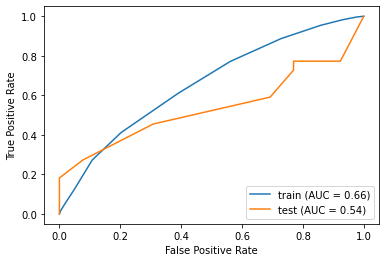

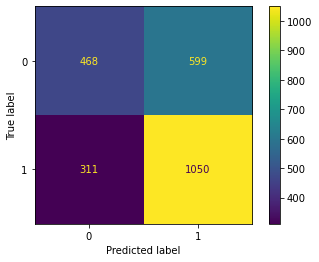

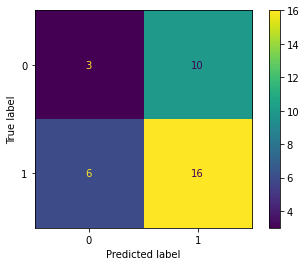

In [156]:
knn(zero_imp_train,zero_imp_test,y_train,y_test)

### Home win KNN

Number of Neighbors: 17
Metric: minkowski
Weights: uniform
Mean Cross-Val Score: 0.544081286326418
Train Mean Accuracy: 0.6186161449752883
Test Mean Accuracy: 0.5428571428571428
Recall Score: 0.7058823529411765
Precision Score: 0.5217391304347826
F1 score: 0.6


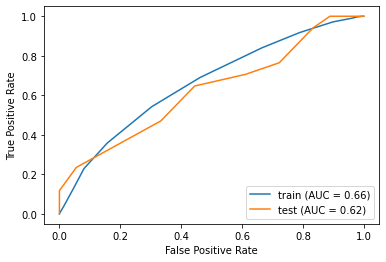

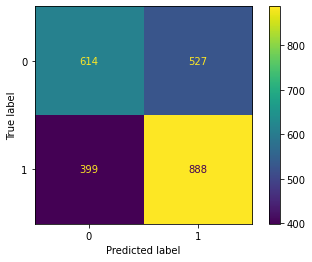

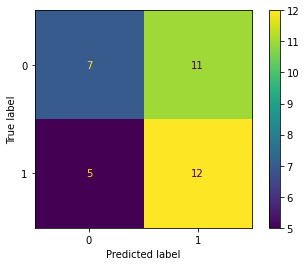

In [162]:
knn(zero_imp_train,zero_imp_test,y_train,y_test)

# Decision Tree

In [172]:
dfeats= feature_select(zero_imp_train,y_train,DecisionTreeClassifier,min_features=10)
X_train_best_tree = zero_imp_train[dfeats]
X_test_best_tree = zero_imp_test[dfeats]

In [173]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    dt_params = gs.best_params_
    
    # Use best max depth from best_params
    dt_max_depth = dt_params['max_depth']
    print(f'Max Depth: {dt_max_depth}')
    
    # Use best minimum sample split from best_params
    dt_min_samp = dt_params['min_samples_split']
    print(f'Min Sample Split: {dt_min_samp}')
    
    # Use best criterion from best_params
    dt_criterion = dt_params['criterion']
    print(f'criterion: {dt_criterion}')
    
    # Instantiate & fit Decision Tree model
    dtree = DecisionTreeClassifier(max_depth=dt_max_depth, criterion=dt_criterion,
                                   min_samples_split=dt_min_samp, random_state=42)
    dtree.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = dtree.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(dtree, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = dtree.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = dtree.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(dtree, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(dtree, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(dtree, X_train, y_train)
    plot_confusion_matrix(dtree, X_test, y_test)

### Dtree Home Win

Max Depth: 3
Min Sample Split: 2
criterion: entropy
Mean Cross-Val Score: 0.5646557210131092
Train Mean Accuracy: 0.5914332784184514
Test Mean Accuracy: 0.5714285714285714
Recall Score: 1.0
Precision Score: 0.53125
F1 score: 0.6938775510204082


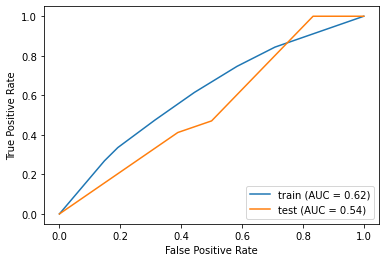

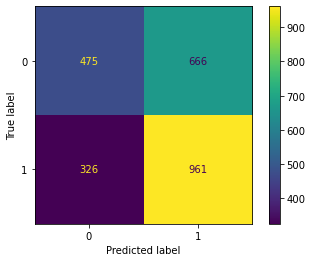

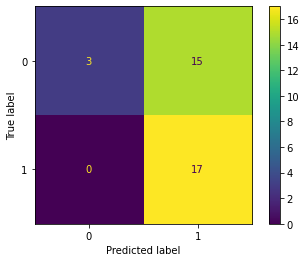

In [166]:
dtree(X_train_best_tree,X_test_best_tree,y_train,y_test)

### Dtree Fav Win

Max Depth: 3
Min Sample Split: 2
criterion: entropy
Mean Cross-Val Score: 0.5490119214288744
Train Mean Accuracy: 0.5642504118616145
Test Mean Accuracy: 0.6
Recall Score: 0.8181818181818182
Precision Score: 0.6428571428571429
F1 score: 0.7200000000000001


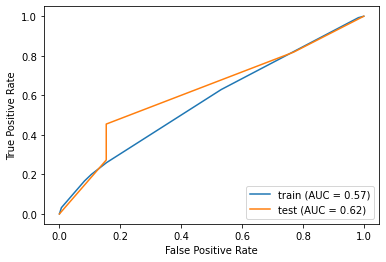

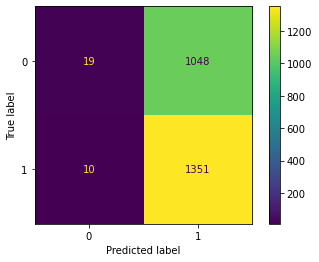

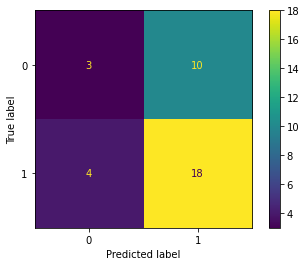

In [174]:
dtree(X_train_best_tree,X_test_best_tree,y_train,y_test)

# Random Forest

In [183]:
rfeats= feature_select(zero_imp_train,y_train,RandomForestClassifier,min_features=10)
X_train_best_for = zero_imp_train[rfeats]
X_test_best_for = zero_imp_test[rfeats]

### Model

In [176]:
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    grid_rf.fit(X_train,y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    rf_params = gs.best_params_
    
    # Use best # of trees from best_params
    rf_n_estimators = rf_params['n_estimators']
    print(f'Number of Trees: {rf_n_estimators}')
    
    # Use best criterion from best_params
    rf_criterion = rf_params['criterion']
    print(f'criterion: {rf_criterion}')
    
    # Instantiate & fit Random Forest model
    rforest = RandomForestClassifier(n_estimators=rf_n_estimators, criterion=rf_criterion,
                                    random_state=42)
    rforest.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = rforest.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(rforest, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = rforest.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = rforest.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(rforest, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(rforest, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(rforest, X_train, y_train)
    plot_confusion_matrix(rforest, X_test, y_test);


### RForest Fav Win

Number of Trees: 500
criterion: gini
Mean Cross-Val Score: 0.5173119511263841
Train Mean Accuracy: 0.6948105436573312
Test Mean Accuracy: 0.6285714285714286
Recall Score: 1.0
Precision Score: 0.6285714285714286
F1 score: 0.7719298245614035


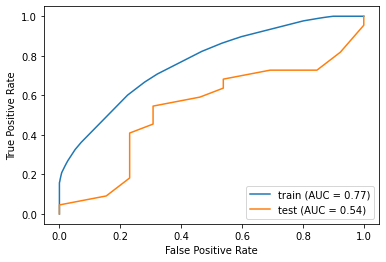

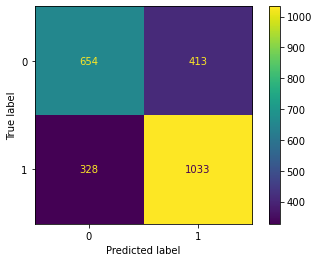

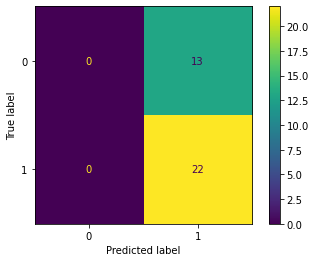

In [177]:
random_forest(X_train_best_for,X_test_best_for,y_train,y_test)

### RForest Home Win

Number of Trees: 125
criterion: entropy
Mean Cross-Val Score: 0.5218387000975776
Train Mean Accuracy: 0.6948105436573312
Test Mean Accuracy: 0.5714285714285714
Recall Score: 1.0
Precision Score: 0.53125
F1 score: 0.6938775510204082


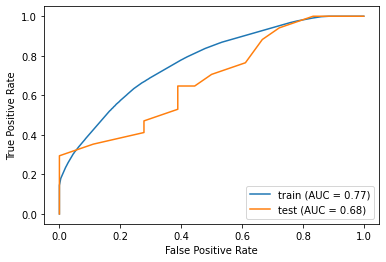

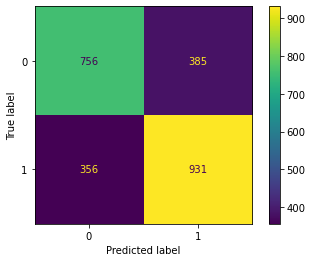

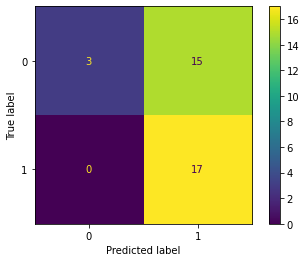

In [184]:
random_forest(X_train_best_for,X_test_best_for,y_train,y_test)

# Bagging Classifier

In [68]:
def bagged(X_train, X_test, y_train, y_test, cv=5):

    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'base_estimator__max_depth': [2,5,15],
    'base_estimator__criterion': ['gini', 'entropy'],
    'max_samples': [1,2,3,5],
    'max_features': [1,2,3,5],
    'n_estimators': [10,50,100,500]}
    
    # Instantiate & fit Bagging Classifier model for GridSearch
    grid_bag = BaggingClassifier(DecisionTreeClassifier(), random_state=42)
    grid_bag.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_bag, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    bag_params = gs.best_params_
    
    # Use best max depth from best_params
    bag_max_depth = bag_params['base_estimator__max_depth']
    print(f'Dec Tree Max Depth: {bag_max_depth}')
    
    # Use best criterion from best_params
    bag_criterion = bag_params['base_estimator__criterion']
    print(f'Dec Tree Criterion: {bag_criterion}')
    
    # Use best max samples from best_params
    bag_max_sample = bag_params['max_samples']
    print(f'Bagging Max Samples: {bag_max_sample}')
    
    # Use best max features from best_params
    bag_max_features = bag_params['max_features']
    print(f'Bag Max Features: {bag_max_features}')
    
    # Use best estimators from best_params
    bag_estimators = bag_params['n_estimators']
    print(f'# of Base Estimators: {bag_estimators}')
    
    # Instantiate & fit Bagging Classifier model
    bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=bag_max_depth,
                                criterion=bag_criterion), max_samples=bag_max_sample,
                                max_features=bag_max_features, n_estimators=bag_estimators,
                                random_state=42)
    bagging.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = bagging.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(bagging, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = bagging.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = bagging.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(bagging, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(bagging, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(bagging, X_train, y_train)
    plot_confusion_matrix(bagging, X_test, y_test);

In [185]:
#bagged(X_train_best_tree,X_test_best_tree,y_train,y_test)

# XGBoost

In [88]:
xfeats= feature_select(X_train,y_train,XGBClassifier,min_features=10)
X_train_best_x = X_train[xfeats]
X_test_best_x = X_test[xfeats]

In [89]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.05,.1,.2,.3],
    'max_depth': [3,6,10],
    'min_child_weight': [1,2],
    'subsample': [.5,.7,1],
    'n_estimators': [100,300,500],
    'early_stopping_rounds': [15]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    xgb_params = gs.best_params_
    
    # Use best learning rate from best_params
    xgb_lr = xgb_params['learning_rate']
    print(f'XGBoost Learning Rate: {xgb_lr}')
    
    # Use best max depth from best_params
    xgb_max_depth = xgb_params['max_depth']
    print(f'XGBoost Max Depth: {xgb_max_depth}')
    
    # Use best min child weight from best_params
    xgb_min_child_weight = xgb_params['min_child_weight']
    print(f'XGBoost Min Child Weight: {xgb_min_child_weight}')
    
    # Use best subsample from best_params
    xgb_subsample = xgb_params['subsample']
    print(f'XGBoost Subsample: {xgb_subsample}')
    
    # Use best estimators from best_params
    xgb_estimators = xgb_params['n_estimators']
    print(f'XGBoost Estimators: {xgb_estimators}')
    
    # Use best criterion from best_params
    xgb_stop = xgb_params['early_stopping_rounds']
    print(f'Stopped in Round: {xgb_stop}')
    
    # Create prediction variable using test data
    y_pred = xgb.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(xgb, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = xgb.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = xgb.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(xgb, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(xgb, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(xgb, X_train, y_train)
    plot_confusion_matrix(xgb, X_test, y_test);

In [186]:
#xgboost(X_train_best_x, X_test_best_x, y_train, y_test, cv=5)